In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FixedLocator, NullLocator
import time

In [62]:
def arg(z):
    ans = np.arctan2(z[1],z[0])
    if ans<0:
        return ans+2*np.pi
    else:
        return ans
    
def step_mat(K,dt):
    if K<0:
        return np.array([[np.cosh(dt*np.sqrt(-K)),np.sqrt(-K)*np.sinh(dt*np.sqrt(-K))],[1/np.sqrt(-K)*np.sinh(dt*np.sqrt(-K)),np.cosh(dt*np.sqrt(-K))]])
    if K==0:
        return np.array([[1,0],[dt,1]])
    if K>0:
        return np.array([[np.cos(dt*np.sqrt(K)),-np.sqrt(K)*np.sin(dt*np.sqrt(K))],[1/np.sqrt(K)*np.sin(dt*np.sqrt(K)),np.cos(dt*np.sqrt(K))]])
    
def new_arg(old_arg, K, dt):
    old_z = [np.cos(old_arg), np.sin(old_arg)]
    new_z = old_z @ step_mat(K, dt)
    return arg(new_z)

def new_sost(DP, old_sost, K, dt):
    oarg = np.pi / DP * (1 + 2 * old_sost)
    narg = new_arg(oarg, K, dt)
    return int(np.floor(narg * DP / 2 / np.pi))

Разбиваем окружность на $DP$ кусков, множество состояний будет $\{\frac{\pi}{DP},...,2\pi-\frac{\pi}{DP}\}$

In [204]:
DP = 900
MS = np.linspace(np.pi/DP,(2-1/DP)*np.pi,DP)
#MS

Возьмём набор значений $K$ $\{-1, -0.5, 0, 0.5, 1\}$ и для каждого состояния вычислим углы, в которые оно перейдёт за время 1 при этих значениях $K$. Составим таблицу.

In [205]:
K_set = np.linspace(-1.0, 1.0, 5)
table_content = {}
table_content['arg'] = MS * 360 / 2 / np.pi
for K in K_set:
    col = []
    for i in range(DP):
        col.append(new_arg(MS[i], K, 1.0) * 360 / 2 / np.pi)
    table_content['K = ' + str(K)] = col
df = pd.DataFrame(table_content, index = list(range(DP)))

In [206]:
df

,arg,K = -1.0,K = -0.5,K = 0.0,K = 0.5,K = 1.0
0,0.2,37.345669,23.399035,0.199304,329.111462,302.90422
1,0.6,37.450579,23.608207,0.593782,329.615309,303.30422
2,1.0,37.554115,23.814277,0.982848,330.116022,303.70422
3,1.4,37.656312,24.017329,1.366614,330.613604,304.10422
4,1.8,37.757205,24.217443,1.745191,331.108058,304.50422
...,...,...,...,...,...,...
895,358.2,36.799145,22.303552,358.141638,326.545268,300.90422
896,358.6,36.911514,22.529576,358.564942,327.064759,301.30422
897,359.0,37.022310,22.752040,358.982239,327.581128,301.70422
898,359.4,37.131573,22.971042,359.393651,328.094370,302.10422


Завершим дискретизацию нашей модели. Теперь значения, получающиеся после шага на 1, будем округлять до ближайшего состояния. Составим таблицу, показывающую куда переходит каждое состояние при разных значениях параметра $K$.

In [207]:
K_set = np.linspace(-1.0, 1.0, 5)
table_content_d = {}
for K in K_set:
    col = []
    for i in range(DP):
        col.append(new_sost(DP, i, K, 1.0))
    table_content_d['K = ' + str(K)] = col
df_d = pd.DataFrame(table_content_d, index = list(range(DP)))

In [208]:
df_d

,K = -1.0,K = -0.5,K = 0.0,K = 0.5,K = 1.0
0,93,58,0,822,757
1,93,59,1,824,758
2,93,59,2,825,759
3,94,60,3,826,760
4,94,60,4,827,761
...,...,...,...,...,...
895,91,55,895,816,752
896,92,56,896,817,753
897,92,56,897,818,754
898,92,57,898,820,755


Для каждого состояния $EN$ раз сгенерируем случайную величину $K$, запишем, в какое состояние оно перейдёт под действием такой кривизны. Таким образом получим матрицу переходов

In [209]:
EN = 50000
prob_mat = np.zeros((DP, DP))

start = time.time()

for sost in range(DP):
    if sost == int(0.2*DP):
       print('20%')
    if sost == int(0.4*DP):
       print('40%')
    if sost == int(0.6*DP):
       print('60%')
    if sost == int(0.8*DP):
       print('80%')
    for isp in range(EN):
        K = np.random.uniform(0,0.57735)
        nsost = new_sost(DP, sost, K, 1.0)
        prob_mat[sost][nsost] += 1
prob_mat /= EN

finish = time.time()
print(f'{finish - start} seconds')

20%
40%
60%
80%
5637.8380336761475 seconds


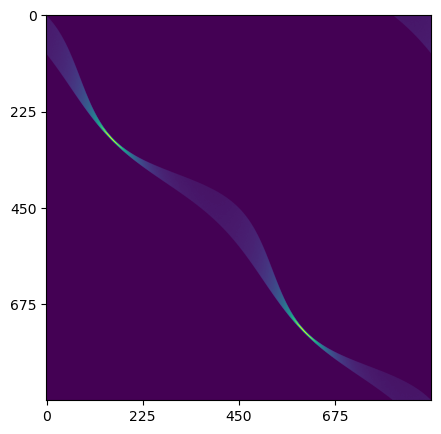

In [210]:
cmap_name = 'viridis'
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
ax.imshow(np.linalg.matrix_power(prob_mat,1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax.grid()
plt.show()

Посмотрим на то, как меняется матрица переходов при возведении её в степень ( = увеличении числа ходов)

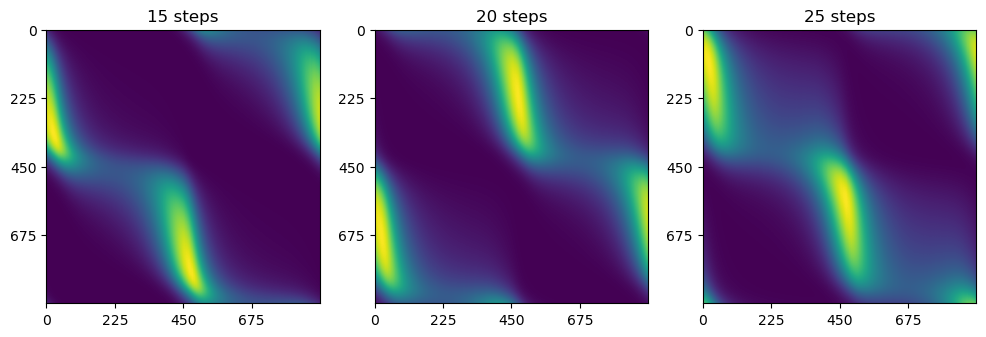

In [220]:
steps_num_1 = 15
steps_num_2 = 20
steps_num_3 = 25

fig = plt.figure(figsize = (12,4))

ax1 = plt.subplot(1,3,1)
ax1.imshow(np.linalg.matrix_power(prob_mat,steps_num_1), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax1.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax1.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax1.grid()
ax1.title.set_text(f'{steps_num_1} steps')

ax2 = plt.subplot(1,3,2)
ax2.imshow(np.linalg.matrix_power(prob_mat,steps_num_2), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax2.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax2.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax2.grid()
ax2.title.set_text(f'{steps_num_2} steps')

ax3 = plt.subplot(1,3,3)
ax3.imshow(np.linalg.matrix_power(prob_mat,steps_num_3), origin = 'upper', cmap = cmap_name, vmin = 0.0)
ax3.xaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
ax3.yaxis.set_major_locator(FixedLocator(np.linspace(0,DP,5)))
#ax3.grid()
ax3.title.set_text(f'{steps_num_3} steps')

plt.show()

In [213]:
np.save('K_norm_0_0.57735_DP_900_EN_50000', prob_mat) 
#prob_mat = np.load('some_array.npy')

In [216]:
for i in range(120,121):
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot()
    ax.imshow(np.linalg.matrix_power(prob_mat,i), origin = 'upper', cmap = cmap_name, vmin = 0.0)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    ax.title.set_text('K~N(0,0.577)')
    #ax.grid()
    #plt.show()
    my_dpi = 100
    #fig.savefig(f'my_fig_{i}.png', dpi=my_dpi)
    fig.savefig(f'N_{i}', dpi=my_dpi)
    plt.close()